Author: Carlos Roberto de Melo
    
Date: 12/11/2020
    
Goal: Mask the arcs in F160w image, and then interpolate over them.

In [77]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

path = "/home/carlos/Desktop/SDP/Dynamics/HST Data Reduction/Data/"

## Selecting only the arcs

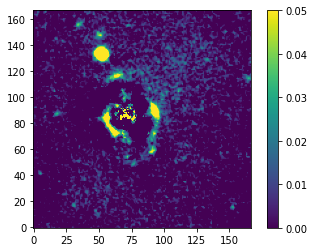

In [78]:
#Load image residual

hdu = fits.open(path + "F160w_difference.fits") #Image
img = hdu[0].data                               #Image data

#Plot img

plt.imshow(img, origin="lower", vmin=0, vmax=0.05)
plt.colorbar()
plt.show()

In [79]:
import scribbler

#Select and drawn the mask
scribbler = scribbler.Scribbler(image=img)

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/carlos/anaconda3/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/carlos/anaconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 259, in resize
    self.draw()
  File "/home/carlos/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/home/carlos/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/home/carlos/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x7f239efc3bd0>
Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/carlos/anaconda3/lib

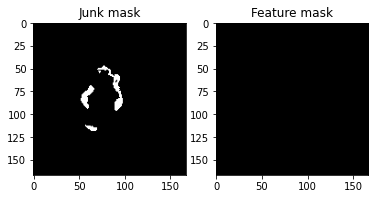

In [80]:
mask = scribbler.show_mask()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/carlos/anaconda3/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/carlos/anaconda3/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/carlos/anaconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/home/carlos/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/home/carlos/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/home/carlos/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x7f23b97

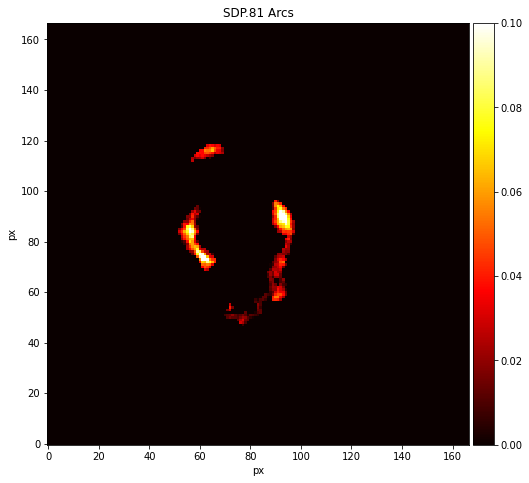

In [81]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.figure(figsize=(8,8))
ax = plt.gca()

plt.title("SDP.81 Arcs")
plot = plt.imshow(img*mask, origin="lower", interpolation="nearest", vmin=0, vmax=0.1, cmap="hot")
plt.xlabel("px")
plt.ylabel("px")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(plot, cax=cax)

plt.savefig("/home/carlos/Desktop/SDP/Dynamics/HST Data Reduction/Figs/Interpoleted.png",
                    fmt="png", bbox_inches='tight', dpi=200)

In [82]:
#Saving img with arcs

fits.writeto(filename=path+"arcs.fits", data=img*mask, overwrite=True)

## Masking arcs in the original image

In [83]:
from mpdaf.obj import Image
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

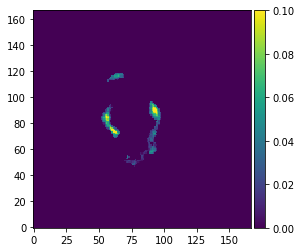

In [84]:
#Open image with arcs

arcs = Image(path+ "arcs.fits")
arcs.plot(vmin=0, vmax=0.1, colorbar="v")

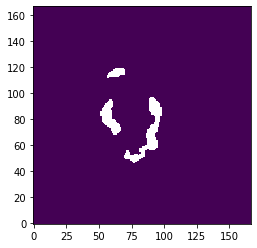

In [85]:
arcs_position = np.where(arcs.data.data !=0)  #Position of the arcs
mask = np.empty_like(arcs.data.data)          #Mask with same dimension of data
mask[:] = 1                                   #All position different from arcs should be iqualto one
mask[arcs_position] = np.nan                       #Arcs position should be nan

plt.imshow(mask, origin="lower")              #Plot mask

fits.writeto(filename=path+"mask.fits", data=mask, overwrite=True)  #Save mask in fits file

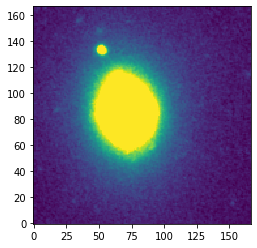

In [86]:
#Open original image

img = Image(path+"F160W_centerized.fits")         #Original
img.plot(zscale=True)

In [87]:
#Mask arcs position using mask created above

img_masked = img*mask
img_masked.write(path+"F160w_without_arcs.fits")

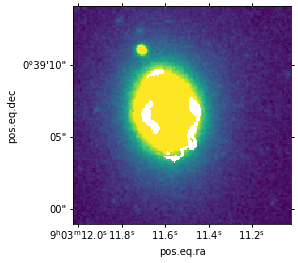

In [88]:
img_masked.plot(zscale=True, use_wcs=True)

## Interpolate Image

In [89]:
from scipy import interpolate
from mpdaf.obj import Image

In [90]:
#Original image *with* arcs to compute the resisual in the end

original = Image(path+"F160W_centerized.fits")

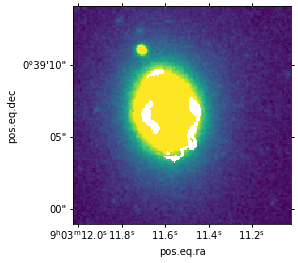

In [91]:
#Image *without* arcs to interpolet across it
img_masked = Image(path+"F160w_without_arcs.fits")
img_masked.plot(zscale=True, use_wcs=True)

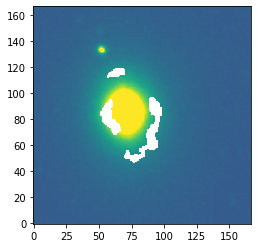

In [92]:
to_interp = img_masked.data.data                      #Just a variable change to save lines
plt.imshow(to_interp, vmin=0, vmax=1, origin="lower") #check data

## Linear interpolation 

In [93]:
#Generating the grid on which the new interpolated image will be stored
x = np.arange(0, to_interp.shape[1])
y = np.arange(0, to_interp.shape[0])

#mask invalid values
to_interp = np.ma.masked_invalid(to_interp)
xx, yy = np.meshgrid(x, y)

#get only the valid values
x1 = xx[~to_interp.mask]
y1 = yy[~to_interp.mask]
newarr = to_interp[~to_interp.mask]

#Interpolation
GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='linear')

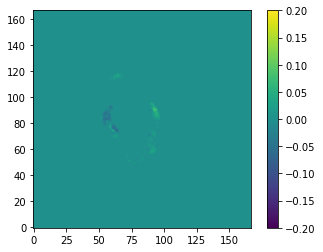

In [95]:
#Returning the interpolated image to the original variable.

img_masked.data.data[:] = GD1

#Plot residual
plt.imshow(original.data.data - img_masked.data.data, origin="lower", vmin=-0.2, vmax=0.2)
plt.colorbar()

fits.writeto(filename=path+"linear_residual.fits", data=original.data.data - img_masked.data.data, overwrite=True)
img_masked.write(path+"F160W_linear_interpolation.fits")

## Cubic interpolation 

In [96]:
#Generating the grid on which the new interpolated image will be stored
x = np.arange(0, to_interp.shape[1])
y = np.arange(0, to_interp.shape[0])

#mask invalid values
to_interp = np.ma.masked_invalid(to_interp)
xx, yy = np.meshgrid(x, y)

#get only the valid values
x1 = xx[~to_interp.mask]
y1 = yy[~to_interp.mask]
newarr = to_interp[~to_interp.mask]

#Interpolation
GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='cubic')

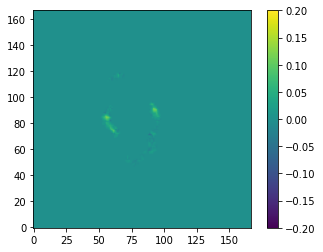

In [97]:
#Returning the interpolated image to the original variable.

img_masked.data.data[:] = GD1

#Plot residual
plt.imshow(original.data.data - img_masked.data.data, origin="lower", vmin=-0.2, vmax=0.2)
plt.colorbar()

fits.writeto(filename=path+"cubic_residual.fits", data=original.data.data - img_masked.data.data, overwrite=True)
img_masked.write(path+"F160W_cubic_interpolation.fits")

## Comparing

In [98]:
linear = Image(path+"F160W_linear_interpolation.fits", ext=1)
cubic = Image(path+"F160W_cubic_interpolation.fits", ext=1)

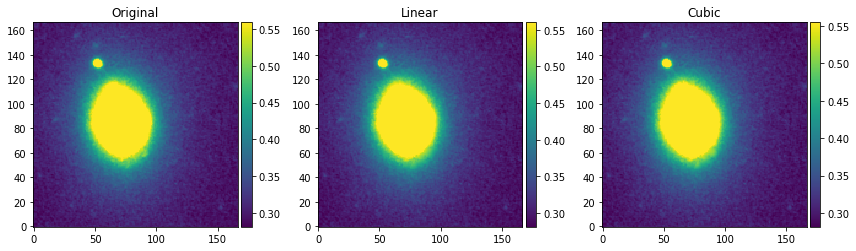

In [99]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

original.plot(ax=ax1, title="Original", colorbar='v', zscale=True)
linear.plot(ax=ax2, title="Linear", colorbar='v', zscale=True)
cubic.plot(ax=ax3, title="Cubic", colorbar='v', zscale=True)

plt.savefig("/home/carlos/Desktop/SDP/Dynamics/HST Data Reduction/Figs/Comparing_Interpolations.png",fmt="png")

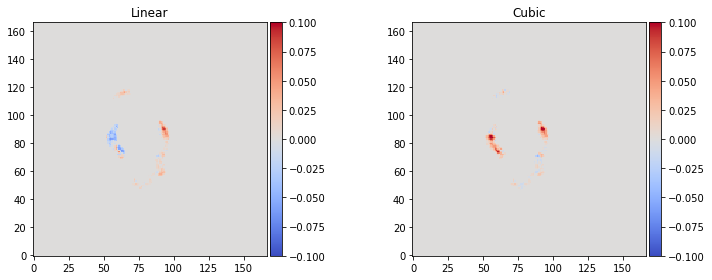

In [100]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

(original-linear).plot(ax=ax1, title="Linear", colorbar='v', zscale=True, cmap="coolwarm")
(original-cubic).plot(ax=ax2, title="Cubic", colorbar='v', zscale=True, cmap="coolwarm")

plt.savefig("/home/carlos/Desktop/SDP/Dynamics/HST Data Reduction/Figs/Residual_Interpolations.png",fmt="png")

## Puting WCS in the Arcs Image

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Image

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/HST Data Reduction/Data/"

In [5]:
arcs   = Image(data_folder+"arcs.fits")                 # Image of the arcs
f160w  = Image(data_folder+"F160W_centerized.fits")     #Original image. We are extracting the WCS from it.

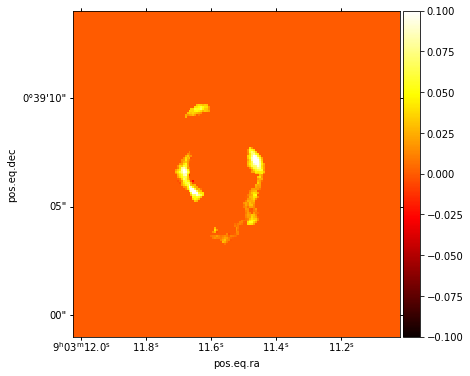

In [13]:
arcs.wcs = f160w.wcs   #Setting the WCS

plt.figure(figsize=(8,6))
arcs.plot(use_wcs=True, zscale=True, colorbar="v", cmap="hot")

In [14]:
arcs.write(data_folder+"arcs_wcs.fits")   #Saving Arcs with WCS